Found 13104 images belonging to 15 classes.
Found 300 images belonging to 15 classes.
Found 750 images belonging to 15 classes.
Detected Classes: ['Aphid', 'Black Rust', 'Blast', 'Brown Rust', 'Common Root Rot', 'Fusarium Head Blight', 'Healthy', 'Leaf Blight', 'Mildew', 'Mite', 'Septoria', 'Smut', 'Stem fly', 'Tan spot', 'Yellow Rust']
Epoch 1/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 407s 823ms/step - accuracy: 0.2977 - loss: 2.6647 - val_accuracy: 0.0767 - val_loss: 3.0081 - learning_rate: 1.0000e-04
Epoch 2/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 305s 731ms/step - accuracy: 0.6456 - loss: 1.1722 - val_accuracy: 0.5267 - val_loss: 2.2277 - learning_rate: 1.0000e-04
Epoch 3/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 300s 720ms/step - accuracy: 0.7191 - loss: 0.8843 - val_accuracy: 0.7267 - val_loss: 2.0534 - learning_rate: 1.0000e-04
Epoch 4/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 304s 729ms/step - accuracy: 0.7633 - loss: 0.7297 - val_accuracy: 0.7733 - val_loss: 1.8687 - learning_rate: 1.0000e-04
Epoch 5/50
410/410 ━━

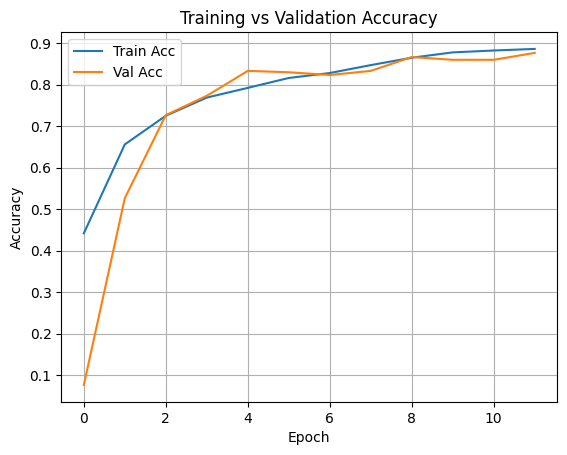

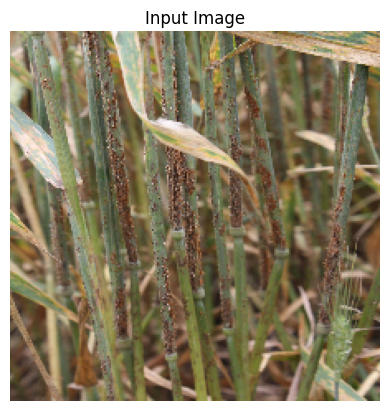

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Class: Black Rust
Confidence: 0.99


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 50

# Paths to dataset
train_dir = "/kaggle/input/wheat-plant-diseases/data/train"
val_dir = "/kaggle/input/wheat-plant-diseases/data/valid"
test_dir = "/kaggle/input/wheat-plant-diseases/data/test"

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

CLASS_NAMES = list(train_generator.class_indices.keys())
NUM_CLASSES = len(CLASS_NAMES)
print("Detected Classes:", CLASS_NAMES)

# Build model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True  # Fine-tuning entire model (or set specific layers later)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Save model
model.save("wheat_disease_classifier_final.keras")

# Accuracy plots
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# ---------- Prediction Function ----------
def predict_image(image_path):
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    confidence = predictions[0][predicted_class]

    print(f"Predicted Class: {CLASS_NAMES[predicted_class]}")
    print(f"Confidence: {confidence:.2f}")

# Example
predict_image("/kaggle/input/wheat-plant-diseases/data/train/Black Rust/black_rust_1.png")


Found 13104 images belonging to 15 classes.
Found 300 images belonging to 15 classes.
Found 750 images belonging to 15 classes.
Detected Classes: ['Aphid', 'Black Rust', 'Blast', 'Brown Rust', 'Common Root Rot', 'Fusarium Head Blight', 'Healthy', 'Leaf Blight', 'Mildew', 'Mite', 'Septoria', 'Smut', 'Stem fly', 'Tan spot', 'Yellow Rust']
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


410/410 ━━━━━━━━━━━━━━━━━━━━ 392s 803ms/step - accuracy: 0.2950 - loss: 2.6853 - val_accuracy: 0.1300 - val_loss: 2.8764 - learning_rate: 1.0000e-04
Epoch 2/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 307s 737ms/step - accuracy: 0.6360 - loss: 1.2036 - val_accuracy: 0.5633 - val_loss: 2.0545 - learning_rate: 1.0000e-04
Epoch 3/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 307s 737ms/step - accuracy: 0.7079 - loss: 0.9092 - val_accuracy: 0.7167 - val_loss: 1.9202 - learning_rate: 1.0000e-04
Epoch 4/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 307s 737ms/step - accuracy: 0.7572 - loss: 0.7500 - val_accuracy: 0.8000 - val_loss: 1.8037 - learning_rate: 1.0000e-04
Epoch 5/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 310s 742ms/step - accuracy: 0.7916 - loss: 0.6319 - val_accuracy: 0.8067 - val_loss: 1.9785 - learning_rate: 1.0000e-04
Epoch 6/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 310s 743ms/step - accuracy: 0.8099 - loss: 0.5690 - val_accuracy: 0.8067 - val_loss: 1.7100 - learning_rate: 1.0000e-04
Epoch 7/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 309s 743ms/

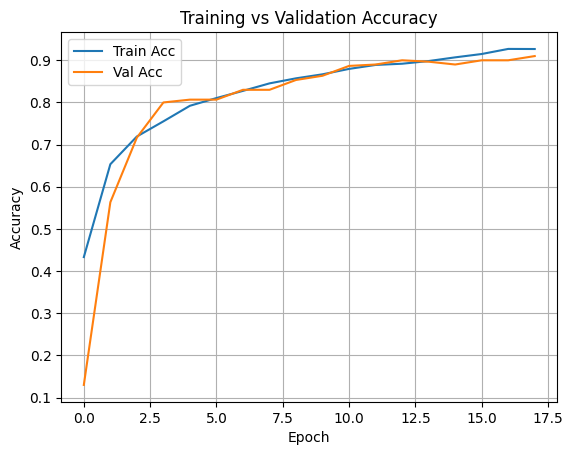

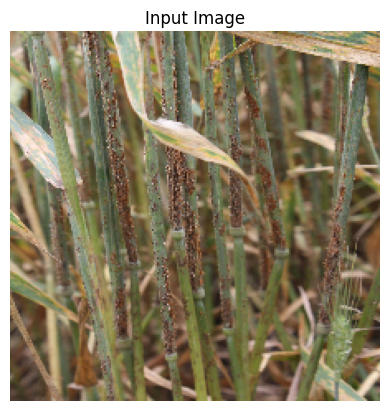

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: Black Rust
Confidence: 1.00

--- Evaluating on Test Data ---
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step


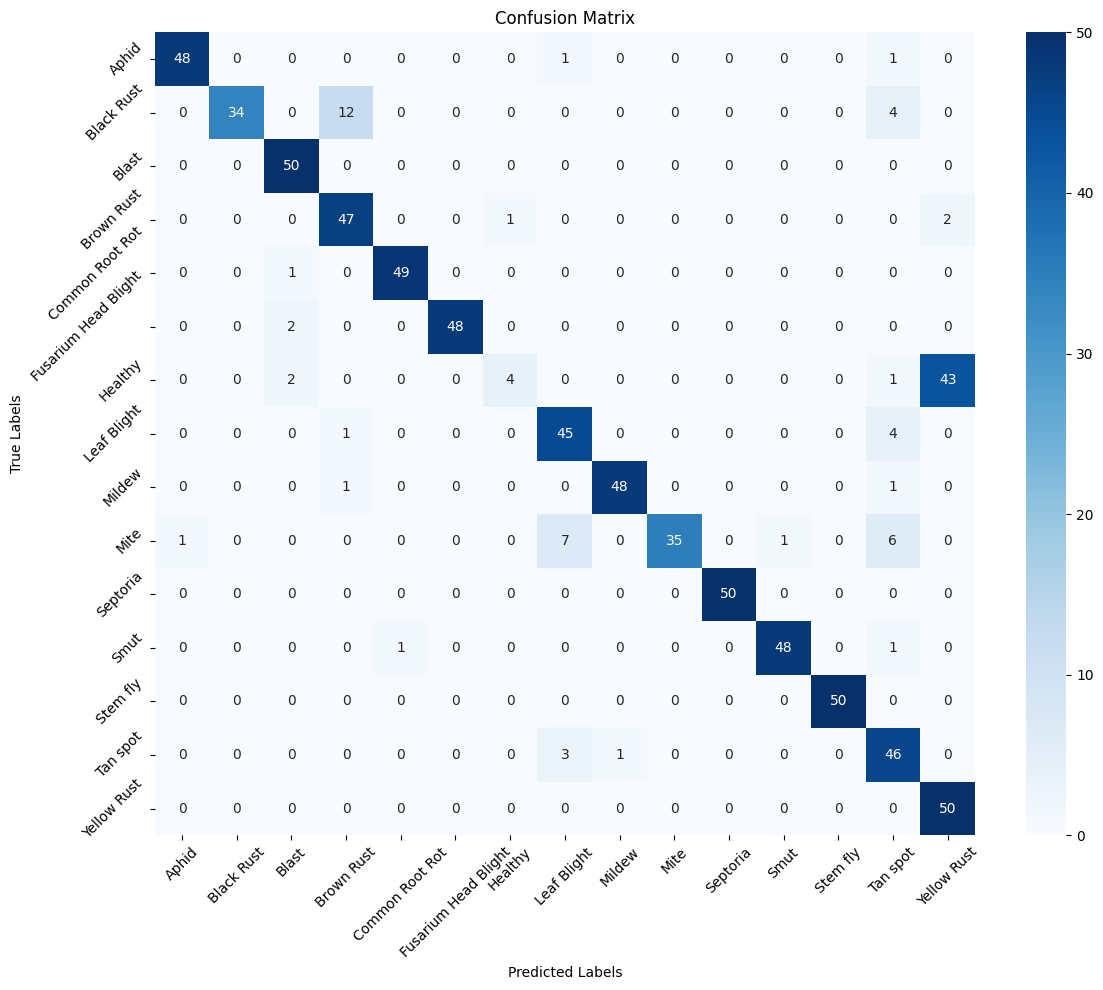

Classification Report:

                      precision    recall  f1-score   support

               Aphid       0.98      0.96      0.97        50
          Black Rust       1.00      0.68      0.81        50
               Blast       0.91      1.00      0.95        50
          Brown Rust       0.77      0.94      0.85        50
     Common Root Rot       0.98      0.98      0.98        50
Fusarium Head Blight       1.00      0.96      0.98        50
             Healthy       0.80      0.08      0.15        50
         Leaf Blight       0.80      0.90      0.85        50
              Mildew       0.98      0.96      0.97        50
                Mite       1.00      0.70      0.82        50
            Septoria       1.00      1.00      1.00        50
                Smut       0.98      0.96      0.97        50
            Stem fly       1.00      1.00      1.00        50
            Tan spot       0.72      0.92      0.81        50
         Yellow Rust       0.53      1.00    

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 50

# Paths to dataset
train_dir = "/kaggle/input/wheat-plant-diseases/data/train"
val_dir = "/kaggle/input/wheat-plant-diseases/data/valid"
test_dir = "/kaggle/input/wheat-plant-diseases/data/test"

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

CLASS_NAMES = list(train_generator.class_indices.keys())
NUM_CLASSES = len(CLASS_NAMES)
print("Detected Classes:", CLASS_NAMES)

# Build model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True  # Fine-tuning entire model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Save model
model.save("wheat_disease_classifier_final.keras")

# Accuracy plots
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# ---------- Prediction Function ----------
def predict_image(image_path):
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    confidence = predictions[0][predicted_class]

    print(f"Predicted Class: {CLASS_NAMES[predicted_class]}")
    print(f"Confidence: {confidence:.2f}")

# Example Prediction
predict_image("/kaggle/input/wheat-plant-diseases/data/train/Black Rust/black_rust_1.png")

# ---------- Confusion Matrix and Classification Report ----------
print("\n--- Evaluating on Test Data ---")
test_generator.reset()
preds = model.predict(test_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))


Found 13104 images belonging to 15 classes.
Found 300 images belonging to 15 classes.
Found 750 images belonging to 15 classes.
Detected Classes: ['Aphid', 'Black Rust', 'Blast', 'Brown Rust', 'Common Root Rot', 'Fusarium Head Blight', 'Healthy', 'Leaf Blight', 'Mildew', 'Mite', 'Septoria', 'Smut', 'Stem fly', 'Tan spot', 'Yellow Rust']
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


410/410 ━━━━━━━━━━━━━━━━━━━━ 614s 1s/step - accuracy: 0.2985 - loss: 2.6994 - val_accuracy: 0.0867 - val_loss: 2.9888 - learning_rate: 1.0000e-04
Epoch 2/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 309s 738ms/step - accuracy: 0.6319 - loss: 1.1987 - val_accuracy: 0.5300 - val_loss: 2.0313 - learning_rate: 1.0000e-04
Epoch 3/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 306s 732ms/step - accuracy: 0.7109 - loss: 0.8989 - val_accuracy: 0.7300 - val_loss: 1.7782 - learning_rate: 1.0000e-04
Epoch 4/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 307s 736ms/step - accuracy: 0.7558 - loss: 0.7261 - val_accuracy: 0.7733 - val_loss: 1.7733 - learning_rate: 1.0000e-04
Epoch 5/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 307s 735ms/step - accuracy: 0.7929 - loss: 0.6221 - val_accuracy: 0.8067 - val_loss: 1.6100 - learning_rate: 1.0000e-04
Epoch 6/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 305s 727ms/step - accuracy: 0.8213 - loss: 0.5517 - val_accuracy: 0.8100 - val_loss: 1.6083 - learning_rate: 1.0000e-04
Epoch 7/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 302s 726ms/ste

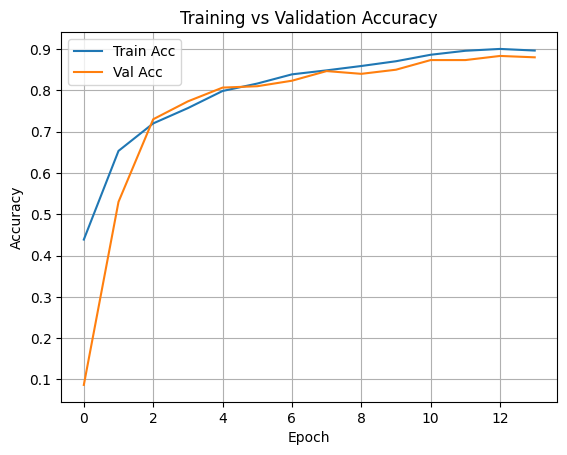

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


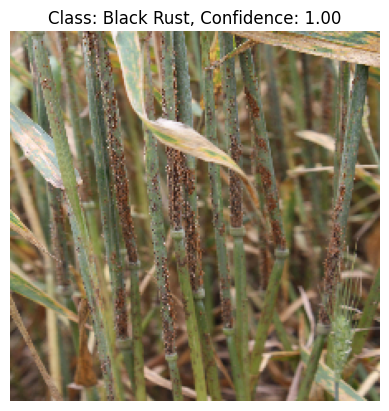

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


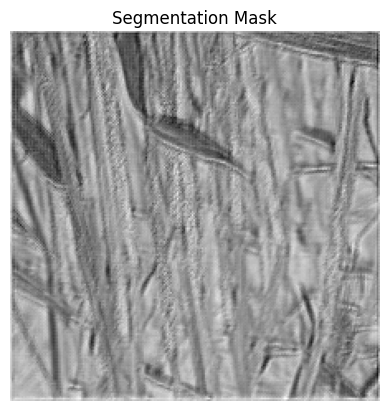


--- Evaluating on Test Data ---
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step


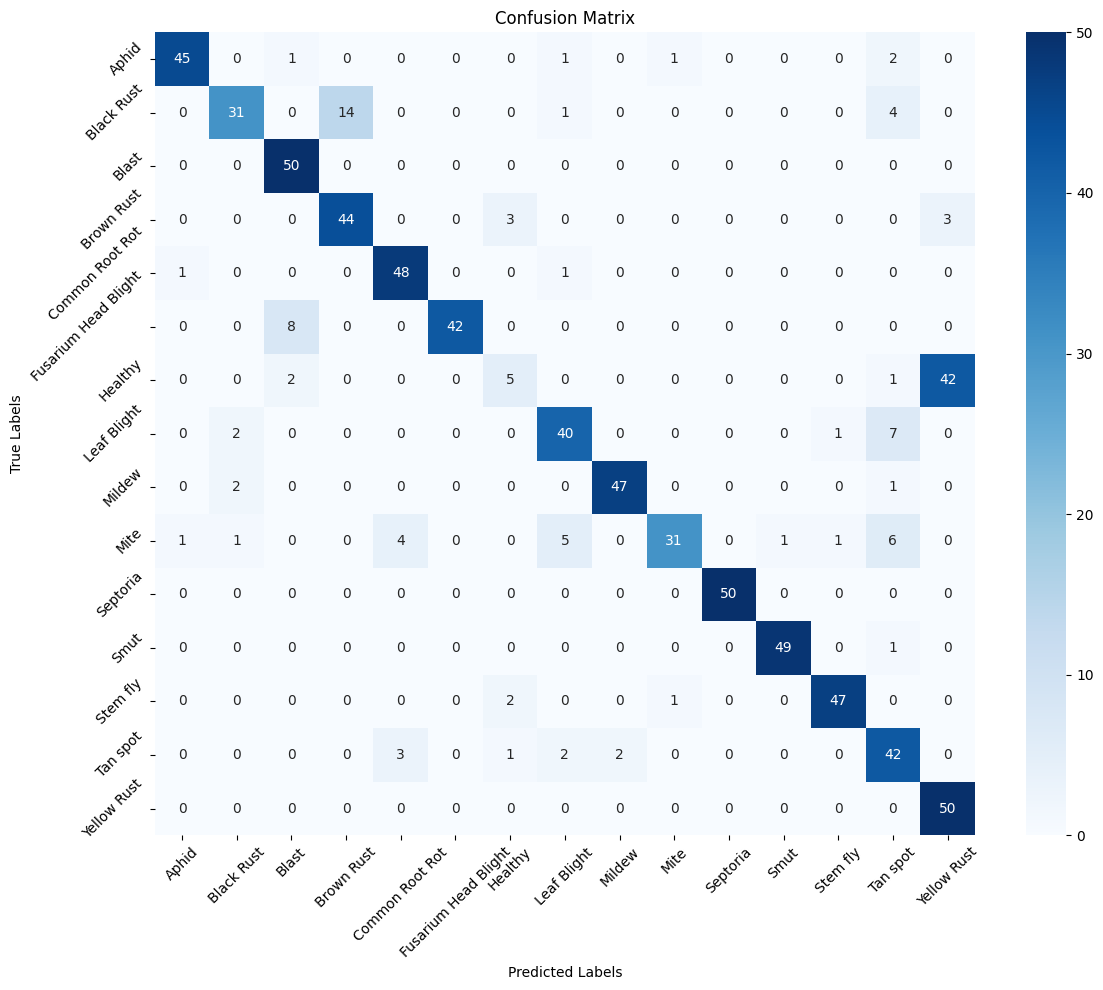

Classification Report:

                      precision    recall  f1-score   support

               Aphid       0.96      0.90      0.93        50
          Black Rust       0.86      0.62      0.72        50
               Blast       0.82      1.00      0.90        50
          Brown Rust       0.76      0.88      0.81        50
     Common Root Rot       0.87      0.96      0.91        50
Fusarium Head Blight       1.00      0.84      0.91        50
             Healthy       0.45      0.10      0.16        50
         Leaf Blight       0.80      0.80      0.80        50
              Mildew       0.96      0.94      0.95        50
                Mite       0.94      0.62      0.75        50
            Septoria       1.00      1.00      1.00        50
                Smut       0.98      0.98      0.98        50
            Stem fly       0.96      0.94      0.95        50
            Tan spot       0.66      0.84      0.74        50
         Yellow Rust       0.53      1.00    

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Conv2D, Conv2DTranspose, Input, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

# Constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 50

# Paths to dataset
train_dir = "/kaggle/input/wheat-plant-diseases/data/train"
val_dir = "/kaggle/input/wheat-plant-diseases/data/valid"
test_dir = "/kaggle/input/wheat-plant-diseases/data/test"

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1, class_mode='categorical', shuffle=False
)

CLASS_NAMES = list(train_generator.class_indices.keys())
NUM_CLASSES = len(CLASS_NAMES)
print("Detected Classes:", CLASS_NAMES)

# Classification Model (EfficientNetB0)
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
classification_model = Model(inputs=base_model.input, outputs=predictions)

classification_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

# Train
history = classification_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

classification_model.save("wheat_disease_classifier_final.keras")

# Accuracy plots
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# --- U-Net Model for Segmentation ---
def build_unet(input_shape=(224, 224, 3), num_classes=1):
    inputs = Input(input_shape)

    def conv_block(x, filters):
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        return x

    def encoder_block(x, filters):
        c = conv_block(x, filters)
        p = MaxPooling2D((2, 2))(c)
        return c, p

    def decoder_block(x, skip, filters):
        x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        x = concatenate([x, skip])
        x = conv_block(x, filters)
        return x

    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)

    bn = conv_block(p4, 1024)

    d1 = decoder_block(bn, c4, 512)
    d2 = decoder_block(d1, c3, 256)
    d3 = decoder_block(d2, c2, 128)
    d4 = decoder_block(d3, c1, 64)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(d4)

    return Model(inputs, outputs, name="U-Net")

unet_model = build_unet()
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Assume model is already trained and loaded for segmentation
# unet_model.load_weights("unet_segmentation_model.h5")

# --- Unified Prediction ---
def predict_image(image_path):
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)

    # Classification prediction
    pred = classification_model.predict(img_batch)
    class_idx = np.argmax(pred)
    confidence = pred[0][class_idx]

    # Plot original
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Class: {CLASS_NAMES[class_idx]}, Confidence: {confidence:.2f}")
    plt.show()

    # If not "Healthy", show segmentation
    if CLASS_NAMES[class_idx].lower() != "healthy":
        seg_mask = unet_model.predict(img_batch)[0]
        plt.imshow(seg_mask.squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Segmentation Mask")
        plt.show()

# Predict
predict_image("/kaggle/input/wheat-plant-diseases/data/train/Black Rust/black_rust_1.png")

# --- Confusion Matrix ---
print("\n--- Evaluating on Test Data ---")
test_generator.reset()
preds = classification_model.predict(test_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))


Found 13104 images belonging to 15 classes.
Found 300 images belonging to 15 classes.
Found 750 images belonging to 15 classes.
Detected Classes: ['Aphid', 'Black Rust', 'Blast', 'Brown Rust', 'Common Root Rot', 'Fusarium Head Blight', 'Healthy', 'Leaf Blight', 'Mildew', 'Mite', 'Septoria', 'Smut', 'Stem fly', 'Tan spot', 'Yellow Rust']
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


410/410 ━━━━━━━━━━━━━━━━━━━━ 543s 1s/step - accuracy: 0.2992 - loss: 2.6422 - val_accuracy: 0.0867 - val_loss: 3.1000 - learning_rate: 1.0000e-04
Epoch 2/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 310s 742ms/step - accuracy: 0.6325 - loss: 1.1615 - val_accuracy: 0.5900 - val_loss: 1.8881 - learning_rate: 1.0000e-04
Epoch 3/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 308s 736ms/step - accuracy: 0.7137 - loss: 0.8985 - val_accuracy: 0.7467 - val_loss: 1.8460 - learning_rate: 1.0000e-04
Epoch 4/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 309s 739ms/step - accuracy: 0.7598 - loss: 0.7157 - val_accuracy: 0.7833 - val_loss: 1.6250 - learning_rate: 1.0000e-04
Epoch 5/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 306s 733ms/step - accuracy: 0.7905 - loss: 0.6355 - val_accuracy: 0.7767 - val_loss: 1.6411 - learning_rate: 1.0000e-04
Epoch 6/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 315s 754ms/step - accuracy: 0.8142 - loss: 0.5549 - val_accuracy: 0.8233 - val_loss: 1.4820 - learning_rate: 1.0000e-04
Epoch 7/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 307s 737ms/ste

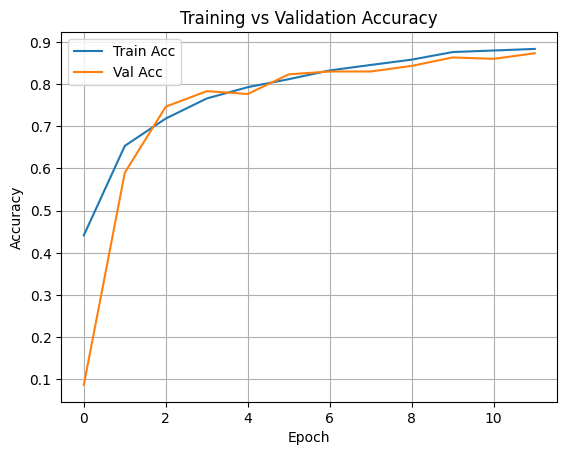

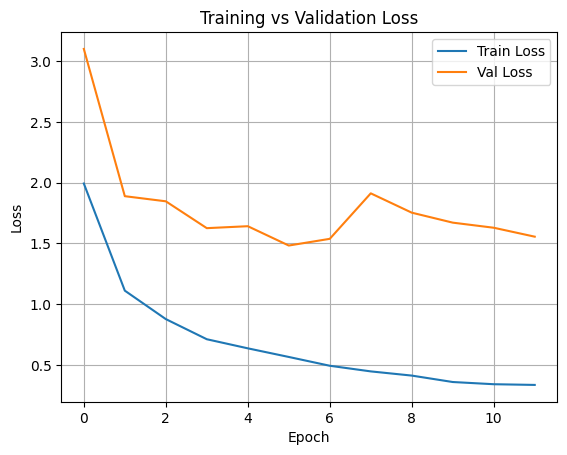

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


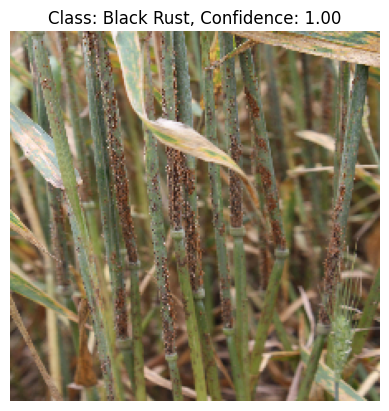

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


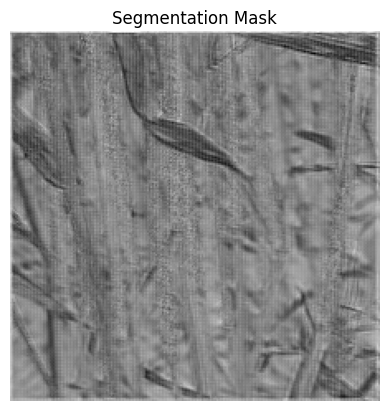


--- Evaluating on Test Data ---
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step


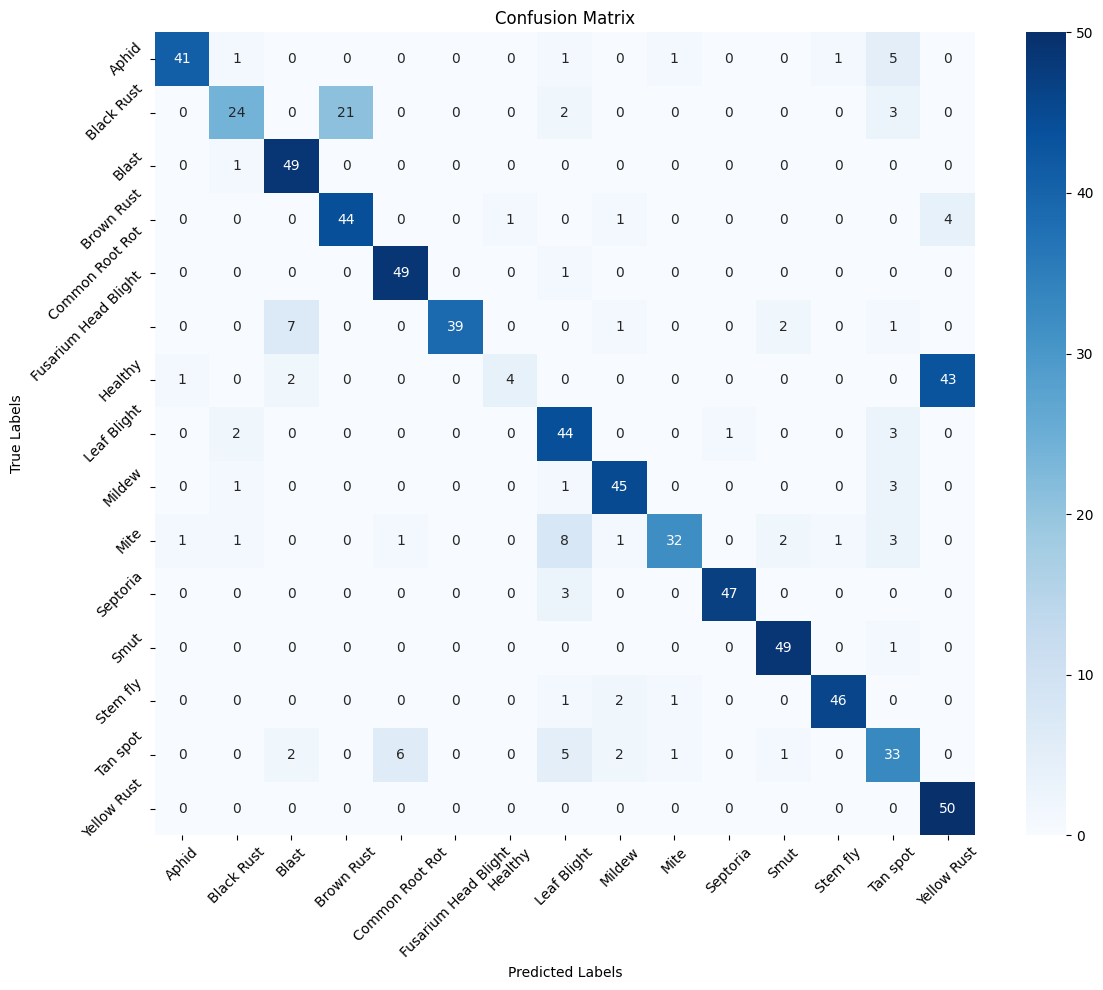

Classification Report:

                      precision    recall  f1-score   support

               Aphid       0.95      0.82      0.88        50
          Black Rust       0.80      0.48      0.60        50
               Blast       0.82      0.98      0.89        50
          Brown Rust       0.68      0.88      0.77        50
     Common Root Rot       0.88      0.98      0.92        50
Fusarium Head Blight       1.00      0.78      0.88        50
             Healthy       0.80      0.08      0.15        50
         Leaf Blight       0.67      0.88      0.76        50
              Mildew       0.87      0.90      0.88        50
                Mite       0.91      0.64      0.75        50
            Septoria       0.98      0.94      0.96        50
                Smut       0.91      0.98      0.94        50
            Stem fly       0.96      0.92      0.94        50
            Tan spot       0.63      0.66      0.65        50
         Yellow Rust       0.52      1.00    

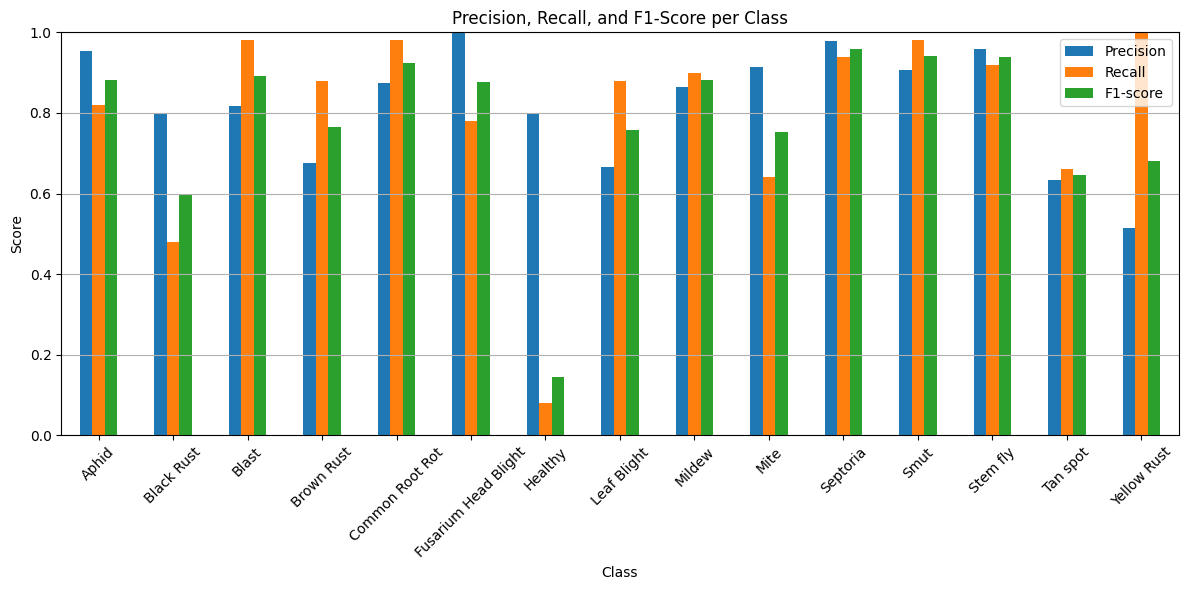

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Conv2D, Conv2DTranspose, Input, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import os
import pandas as pd

# Constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 50

# Paths to dataset
train_dir = "/kaggle/input/wheat-plant-diseases/data/train"
val_dir = "/kaggle/input/wheat-plant-diseases/data/valid"
test_dir = "/kaggle/input/wheat-plant-diseases/data/test"

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1, class_mode='categorical', shuffle=False
)

CLASS_NAMES = list(train_generator.class_indices.keys())
NUM_CLASSES = len(CLASS_NAMES)
print("Detected Classes:", CLASS_NAMES)

# Classification Model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
classification_model = Model(inputs=base_model.input, outputs=predictions)

classification_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

history = classification_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

classification_model.save("wheat_disease_classifier_final.keras")

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- U-Net for Segmentation ---
def build_unet(input_shape=(224, 224, 3), num_classes=1):
    inputs = Input(input_shape)

    def conv_block(x, filters):
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        return x

    def encoder_block(x, filters):
        c = conv_block(x, filters)
        p = MaxPooling2D((2, 2))(c)
        return c, p

    def decoder_block(x, skip, filters):
        x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        x = concatenate([x, skip])
        x = conv_block(x, filters)
        return x

    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)

    bn = conv_block(p4, 1024)

    d1 = decoder_block(bn, c4, 512)
    d2 = decoder_block(d1, c3, 256)
    d3 = decoder_block(d2, c2, 128)
    d4 = decoder_block(d3, c1, 64)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(d4)

    return Model(inputs, outputs, name="U-Net")

unet_model = build_unet()
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Unified Prediction Function
def predict_image(image_path):
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)

    pred = classification_model.predict(img_batch)
    class_idx = np.argmax(pred)
    confidence = pred[0][class_idx]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Class: {CLASS_NAMES[class_idx]}, Confidence: {confidence:.2f}")
    plt.show()

    if CLASS_NAMES[class_idx].lower() != "healthy":
        seg_mask = unet_model.predict(img_batch)[0]
        plt.imshow(seg_mask.squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Segmentation Mask")
        plt.show()

# Example Prediction
predict_image("/kaggle/input/wheat-plant-diseases/data/train/Black Rust/black_rust_1.png")

# --- Evaluation ---
print("\n--- Evaluating on Test Data ---")
test_generator.reset()
preds = classification_model.predict(test_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# Precision, Recall, F1-Score Bar Graph
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=range(NUM_CLASSES))

metrics_df = pd.DataFrame({
    'Class': CLASS_NAMES,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
})

print("\nDetailed Metrics per Class:")
print(metrics_df)

metrics_df.set_index('Class')[['Precision', 'Recall', 'F1-score']].plot(kind='bar', figsize=(12, 6), ylim=(0, 1))
plt.title("Precision, Recall, and F1-Score per Class")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Found 13104 images belonging to 15 classes.
Found 300 images belonging to 15 classes.
Found 750 images belonging to 15 classes.
Detected Classes: ['Aphid', 'Black Rust', 'Blast', 'Brown Rust', 'Common Root Rot', 'Fusarium Head Blight', 'Healthy', 'Leaf Blight', 'Mildew', 'Mite', 'Septoria', 'Smut', 'Stem fly', 'Tan spot', 'Yellow Rust']
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


410/410 ━━━━━━━━━━━━━━━━━━━━ 389s 800ms/step - accuracy: 0.2935 - loss: 2.7517 - val_accuracy: 0.1400 - val_loss: 2.7651 - learning_rate: 1.0000e-04
Epoch 2/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 309s 742ms/step - accuracy: 0.6370 - loss: 1.1733 - val_accuracy: 0.5667 - val_loss: 1.8101 - learning_rate: 1.0000e-04
Epoch 3/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 308s 740ms/step - accuracy: 0.7065 - loss: 0.9008 - val_accuracy: 0.7400 - val_loss: 1.5949 - learning_rate: 1.0000e-04
Epoch 4/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 308s 738ms/step - accuracy: 0.7615 - loss: 0.7284 - val_accuracy: 0.7767 - val_loss: 1.6009 - learning_rate: 1.0000e-04
Epoch 5/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 308s 739ms/step - accuracy: 0.7937 - loss: 0.6142 - val_accuracy: 0.8033 - val_loss: 1.6002 - learning_rate: 1.0000e-04
Epoch 6/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 308s 738ms/step - accuracy: 0.8162 - loss: 0.5556 - val_accuracy: 0.7967 - val_loss: 1.8751 - learning_rate: 1.0000e-04
Epoch 7/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 307s 

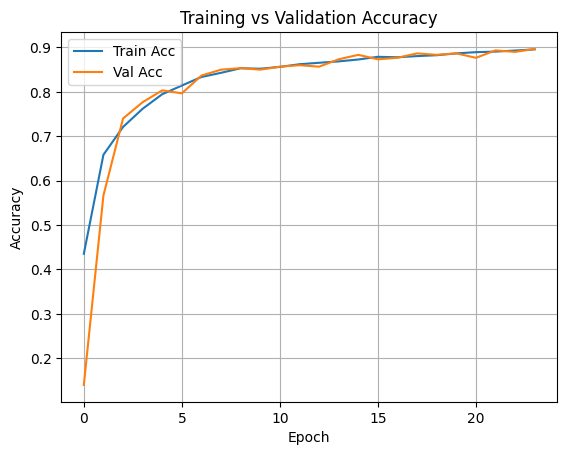

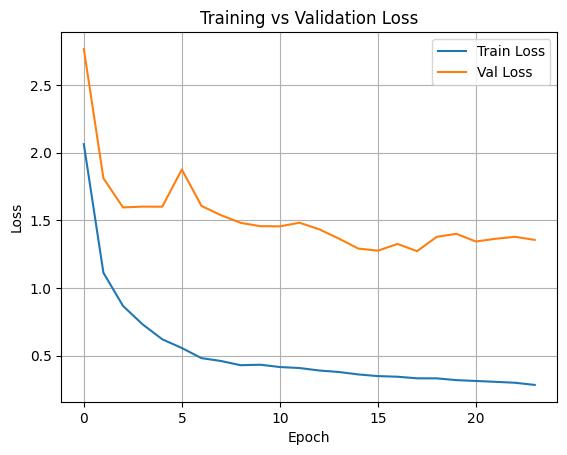

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


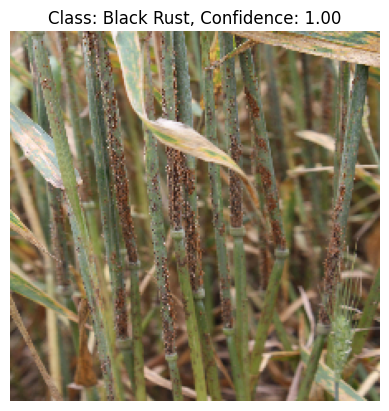

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


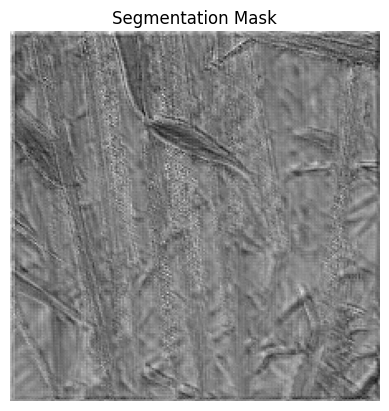


--- Evaluating on Test Data ---
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step


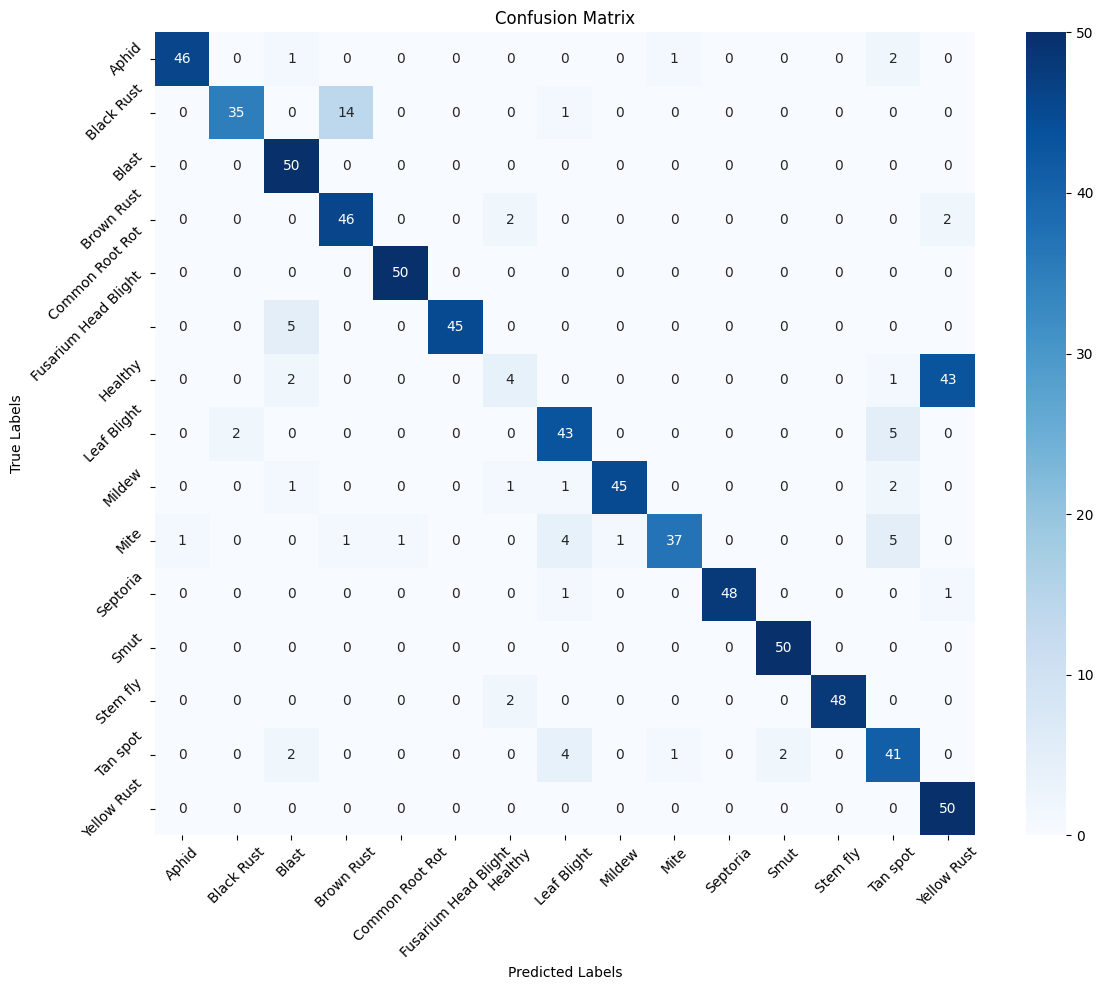

Classification Report:

                      precision    recall  f1-score   support

               Aphid       0.98      0.92      0.95        50
          Black Rust       0.95      0.70      0.80        50
               Blast       0.82      1.00      0.90        50
          Brown Rust       0.75      0.92      0.83        50
     Common Root Rot       0.98      1.00      0.99        50
Fusarium Head Blight       1.00      0.90      0.95        50
             Healthy       0.44      0.08      0.14        50
         Leaf Blight       0.80      0.86      0.83        50
              Mildew       0.98      0.90      0.94        50
                Mite       0.95      0.74      0.83        50
            Septoria       1.00      0.96      0.98        50
                Smut       0.96      1.00      0.98        50
            Stem fly       1.00      0.96      0.98        50
            Tan spot       0.73      0.82      0.77        50
         Yellow Rust       0.52      1.00    

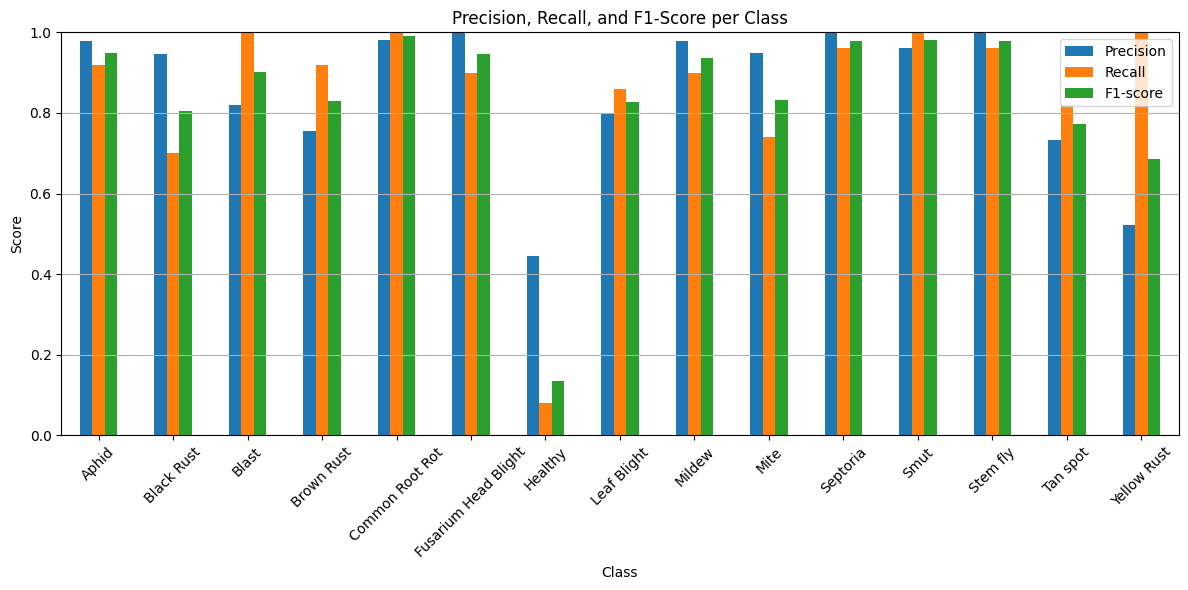

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Conv2D, Conv2DTranspose, Input, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import os
import pandas as pd

# Constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 100

# Paths to dataset
train_dir = "/kaggle/input/wheat-plant-diseases/data/train"
val_dir = "/kaggle/input/wheat-plant-diseases/data/valid"
test_dir = "/kaggle/input/wheat-plant-diseases/data/test"

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1, class_mode='categorical', shuffle=False
)

CLASS_NAMES = list(train_generator.class_indices.keys())
NUM_CLASSES = len(CLASS_NAMES)
print("Detected Classes:", CLASS_NAMES)

# Classification Model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
classification_model = Model(inputs=base_model.input, outputs=predictions)

classification_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

history = classification_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

classification_model.save("wheat_disease_classifier_final.keras")

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- U-Net for Segmentation ---
def build_unet(input_shape=(224, 224, 3), num_classes=1):
    inputs = Input(input_shape)

    def conv_block(x, filters):
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        return x

    def encoder_block(x, filters):
        c = conv_block(x, filters)
        p = MaxPooling2D((2, 2))(c)
        return c, p

    def decoder_block(x, skip, filters):
        x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        x = concatenate([x, skip])
        x = conv_block(x, filters)
        return x

    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)

    bn = conv_block(p4, 1024)

    d1 = decoder_block(bn, c4, 512)
    d2 = decoder_block(d1, c3, 256)
    d3 = decoder_block(d2, c2, 128)
    d4 = decoder_block(d3, c1, 64)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(d4)

    return Model(inputs, outputs, name="U-Net")

unet_model = build_unet()
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Unified Prediction Function
def predict_image(image_path):
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)

    pred = classification_model.predict(img_batch)
    class_idx = np.argmax(pred)
    confidence = pred[0][class_idx]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Class: {CLASS_NAMES[class_idx]}, Confidence: {confidence:.2f}")
    plt.show()

    if CLASS_NAMES[class_idx].lower() != "healthy":
        seg_mask = unet_model.predict(img_batch)[0]
        plt.imshow(seg_mask.squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Segmentation Mask")
        plt.show()

# Example Prediction
predict_image("/kaggle/input/wheat-plant-diseases/data/train/Black Rust/black_rust_1.png")

# --- Evaluation ---
print("\n--- Evaluating on Test Data ---")
test_generator.reset()
preds = classification_model.predict(test_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# Precision, Recall, F1-Score Bar Graph
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=range(NUM_CLASSES))

metrics_df = pd.DataFrame({
    'Class': CLASS_NAMES,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
})

print("\nDetailed Metrics per Class:")
print(metrics_df)

metrics_df.set_index('Class')[['Precision', 'Recall', 'F1-score']].plot(kind='bar', figsize=(12, 6), ylim=(0, 1))
plt.title("Precision, Recall, and F1-Score per Class")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Found 13104 images belonging to 15 classes.
Found 300 images belonging to 15 classes.
Found 750 images belonging to 15 classes.
Detected Classes: ['Aphid', 'Black Rust', 'Blast', 'Brown Rust', 'Common Root Rot', 'Fusarium Head Blight', 'Healthy', 'Leaf Blight', 'Mildew', 'Mite', 'Septoria', 'Smut', 'Stem fly', 'Tan spot', 'Yellow Rust']
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


410/410 ━━━━━━━━━━━━━━━━━━━━ 538s 1s/step - accuracy: 0.3078 - loss: 2.6812 - val_accuracy: 0.0867 - val_loss: 3.0478 - learning_rate: 1.0000e-04
Epoch 2/200
410/410 ━━━━━━━━━━━━━━━━━━━━ 312s 748ms/step - accuracy: 0.6382 - loss: 1.1968 - val_accuracy: 0.6033 - val_loss: 2.0555 - learning_rate: 1.0000e-04
Epoch 3/200
410/410 ━━━━━━━━━━━━━━━━━━━━ 314s 753ms/step - accuracy: 0.7150 - loss: 0.8900 - val_accuracy: 0.7300 - val_loss: 1.8901 - learning_rate: 1.0000e-04
Epoch 4/200
410/410 ━━━━━━━━━━━━━━━━━━━━ 308s 738ms/step - accuracy: 0.7652 - loss: 0.7292 - val_accuracy: 0.8000 - val_loss: 2.0720 - learning_rate: 1.0000e-04
Epoch 5/200
410/410 ━━━━━━━━━━━━━━━━━━━━ 314s 752ms/step - accuracy: 0.7888 - loss: 0.6494 - val_accuracy: 0.7767 - val_loss: 2.0316 - learning_rate: 1.0000e-04
Epoch 6/200
410/410 ━━━━━━━━━━━━━━━━━━━━ 314s 751ms/step - accuracy: 0.8101 - loss: 0.5628 - val_accuracy: 0.8233 - val_loss: 1.6442 - learning_rate: 1.0000e-04
Epoch 7/200
410/410 ━━━━━━━━━━━━━━━━━━━━ 312s 750

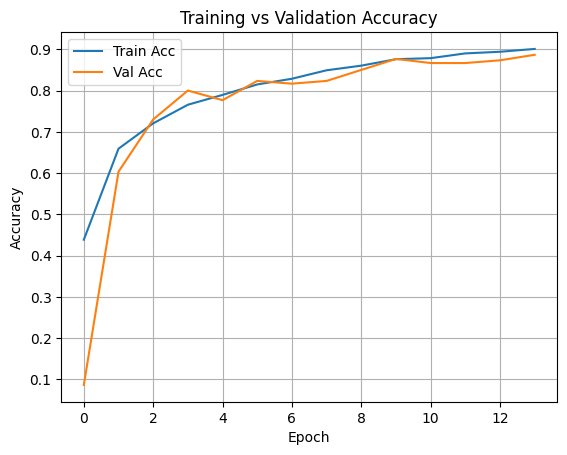

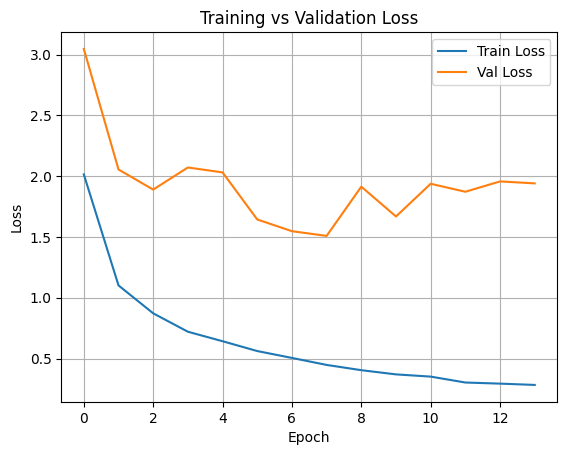

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


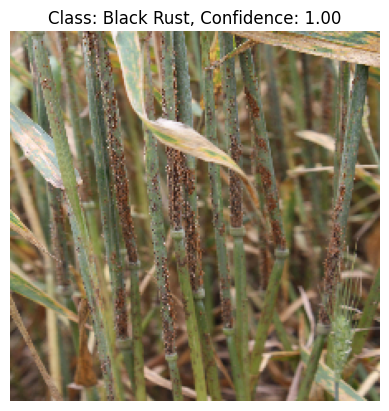

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


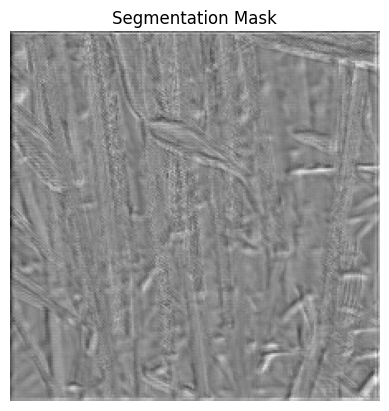


--- Evaluating on Test Data ---
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step


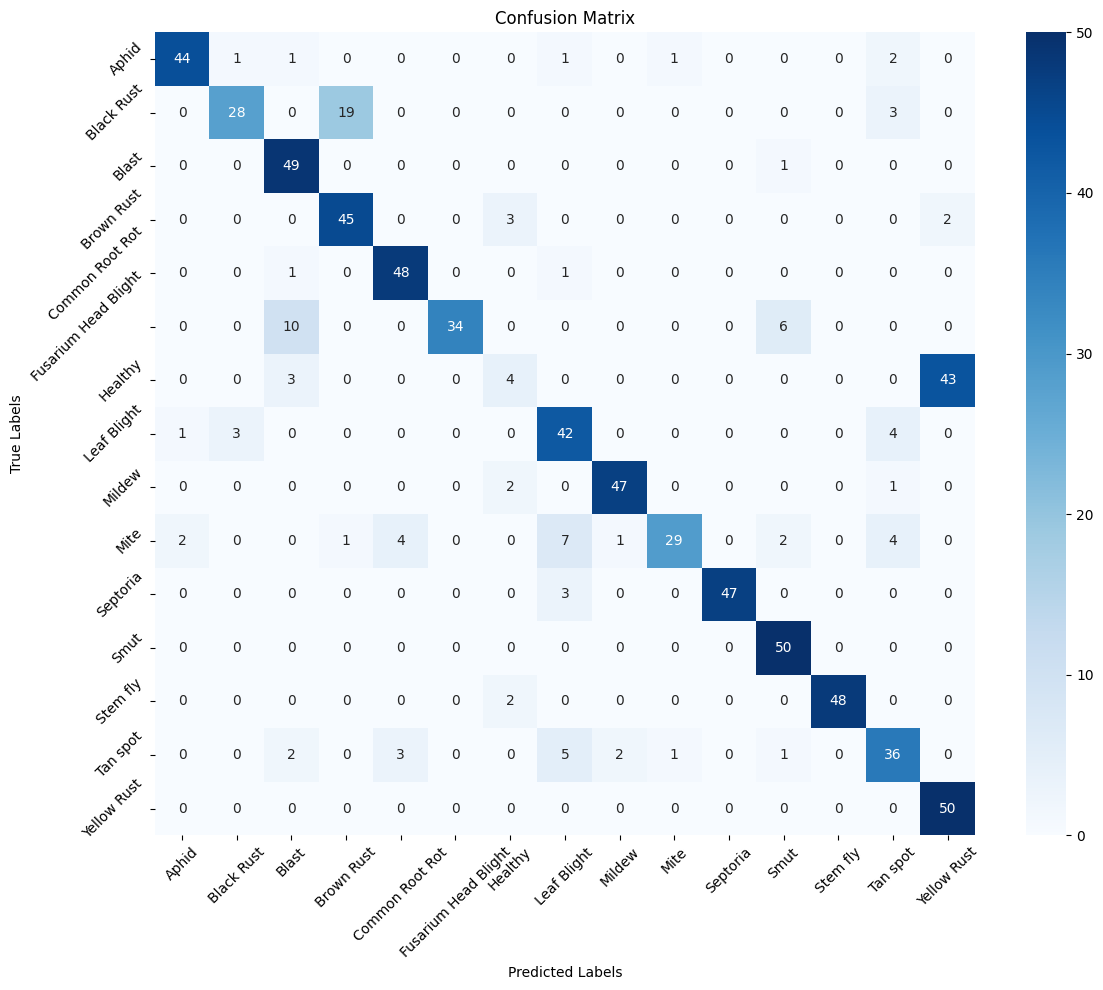

Classification Report:

                      precision    recall  f1-score   support

               Aphid       0.94      0.88      0.91        50
          Black Rust       0.88      0.56      0.68        50
               Blast       0.74      0.98      0.84        50
          Brown Rust       0.69      0.90      0.78        50
     Common Root Rot       0.87      0.96      0.91        50
Fusarium Head Blight       1.00      0.68      0.81        50
             Healthy       0.36      0.08      0.13        50
         Leaf Blight       0.71      0.84      0.77        50
              Mildew       0.94      0.94      0.94        50
                Mite       0.94      0.58      0.72        50
            Septoria       1.00      0.94      0.97        50
                Smut       0.83      1.00      0.91        50
            Stem fly       1.00      0.96      0.98        50
            Tan spot       0.72      0.72      0.72        50
         Yellow Rust       0.53      1.00    

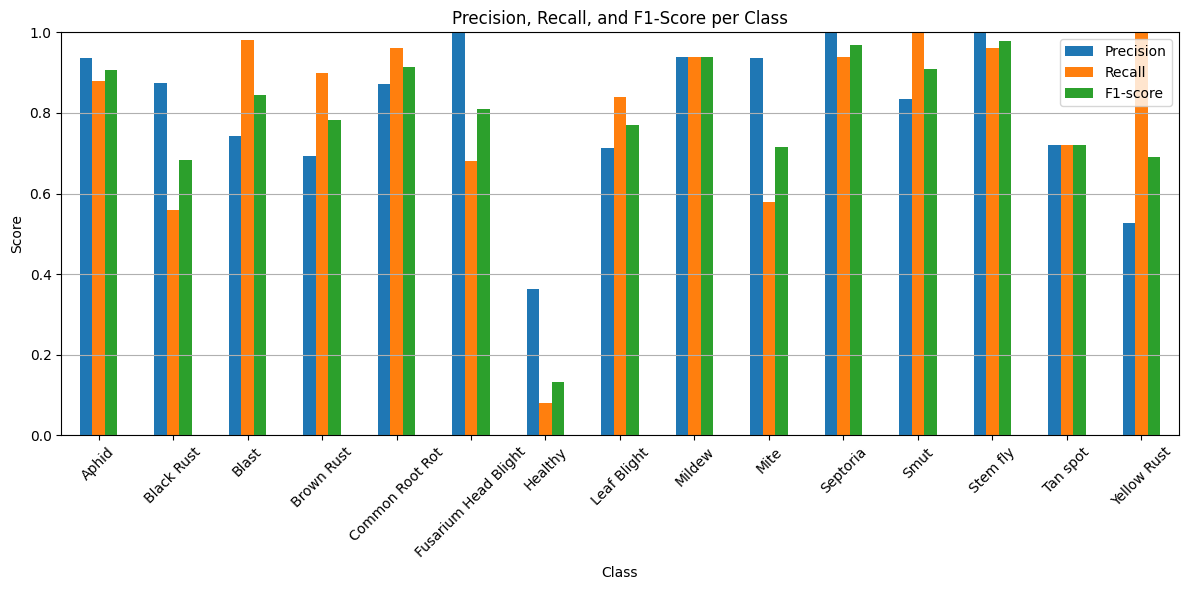

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Conv2D, Conv2DTranspose, Input, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import os
import pandas as pd

# Constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 200

# Paths to dataset
train_dir = "/kaggle/input/wheat-plant-diseases/data/train"
val_dir = "/kaggle/input/wheat-plant-diseases/data/valid"
test_dir = "/kaggle/input/wheat-plant-diseases/data/test"

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1, class_mode='categorical', shuffle=False
)

CLASS_NAMES = list(train_generator.class_indices.keys())
NUM_CLASSES = len(CLASS_NAMES)
print("Detected Classes:", CLASS_NAMES)

# Classification Model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
classification_model = Model(inputs=base_model.input, outputs=predictions)

classification_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

history = classification_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

classification_model.save("wheat_disease_classifier_final.keras")

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- U-Net for Segmentation ---
def build_unet(input_shape=(224, 224, 3), num_classes=1):
    inputs = Input(input_shape)

    def conv_block(x, filters):
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        return x

    def encoder_block(x, filters):
        c = conv_block(x, filters)
        p = MaxPooling2D((2, 2))(c)
        return c, p

    def decoder_block(x, skip, filters):
        x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        x = concatenate([x, skip])
        x = conv_block(x, filters)
        return x

    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)

    bn = conv_block(p4, 1024)

    d1 = decoder_block(bn, c4, 512)
    d2 = decoder_block(d1, c3, 256)
    d3 = decoder_block(d2, c2, 128)
    d4 = decoder_block(d3, c1, 64)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(d4)

    return Model(inputs, outputs, name="U-Net")

unet_model = build_unet()
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Unified Prediction Function
def predict_image(image_path):
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)

    pred = classification_model.predict(img_batch)
    class_idx = np.argmax(pred)
    confidence = pred[0][class_idx]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Class: {CLASS_NAMES[class_idx]}, Confidence: {confidence:.2f}")
    plt.show()

    if CLASS_NAMES[class_idx].lower() != "healthy":
        seg_mask = unet_model.predict(img_batch)[0]
        plt.imshow(seg_mask.squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Segmentation Mask")
        plt.show()

# Example Prediction
predict_image("/kaggle/input/wheat-plant-diseases/data/train/Black Rust/black_rust_1.png")

# --- Evaluation ---
print("\n--- Evaluating on Test Data ---")
test_generator.reset()
preds = classification_model.predict(test_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# Precision, Recall, F1-Score Bar Graph
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=range(NUM_CLASSES))

metrics_df = pd.DataFrame({
    'Class': CLASS_NAMES,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
})

print("\nDetailed Metrics per Class:")
print(metrics_df)

metrics_df.set_index('Class')[['Precision', 'Recall', 'F1-score']].plot(kind='bar', figsize=(12, 6), ylim=(0, 1))
plt.title("Precision, Recall, and F1-Score per Class")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Found 13104 images belonging to 15 classes.
Found 300 images belonging to 15 classes.
Found 750 images belonging to 15 classes.
Detected Classes: ['Aphid', 'Black Rust', 'Blast', 'Brown Rust', 'Common Root Rot', 'Fusarium Head Blight', 'Healthy', 'Leaf Blight', 'Mildew', 'Mite', 'Septoria', 'Smut', 'Stem fly', 'Tan spot', 'Yellow Rust']
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


205/205 ━━━━━━━━━━━━━━━━━━━━ 557s 2s/step - accuracy: 0.2613 - loss: 2.8603 - val_accuracy: 0.0667 - val_loss: 2.7411 - learning_rate: 1.0000e-04
Epoch 2/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.6024 - loss: 1.3111 - val_accuracy: 0.0933 - val_loss: 2.8714 - learning_rate: 1.0000e-04
Epoch 3/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.6808 - loss: 0.9766 - val_accuracy: 0.3267 - val_loss: 2.3174 - learning_rate: 1.0000e-04
Epoch 4/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.7391 - loss: 0.8021 - val_accuracy: 0.6167 - val_loss: 1.6505 - learning_rate: 1.0000e-04
Epoch 5/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - accuracy: 0.7761 - loss: 0.6779 - val_accuracy: 0.7667 - val_loss: 1.4965 - learning_rate: 1.0000e-04
Epoch 6/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.8020 - loss: 0.5987 - val_accuracy: 0.8167 - val_loss: 1.5407 - learning_rate: 1.0000e-04
Epoch 7/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.82

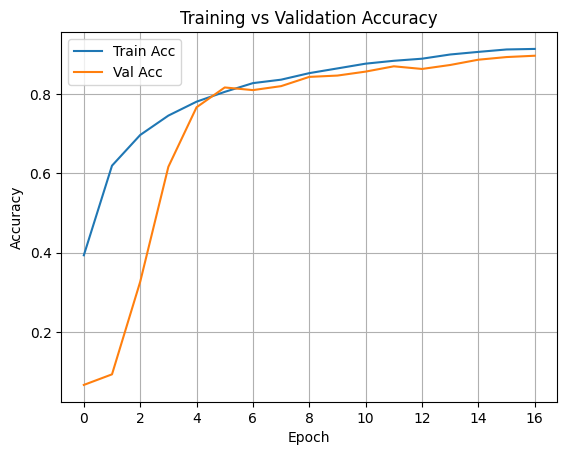

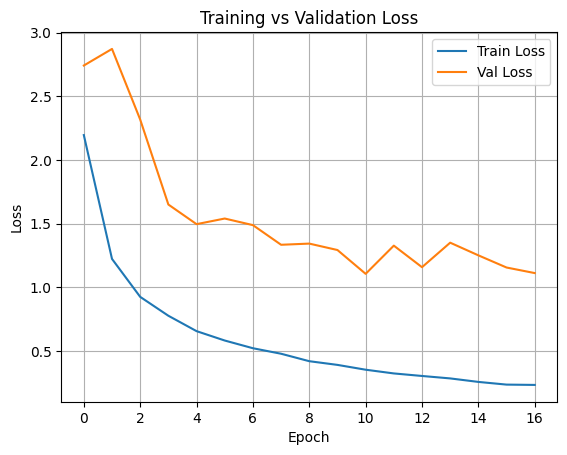

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


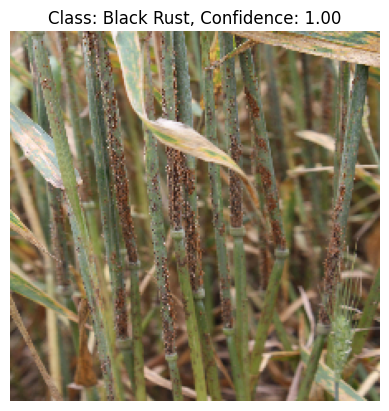

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


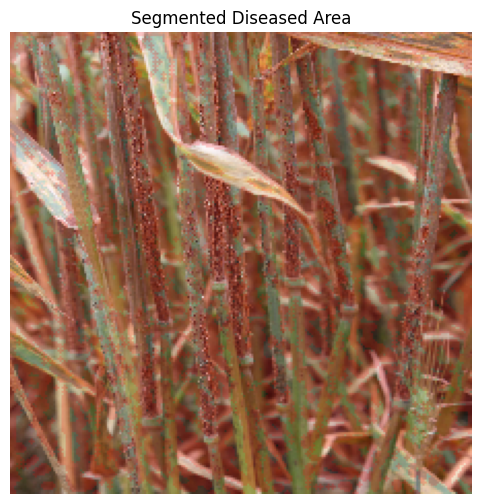

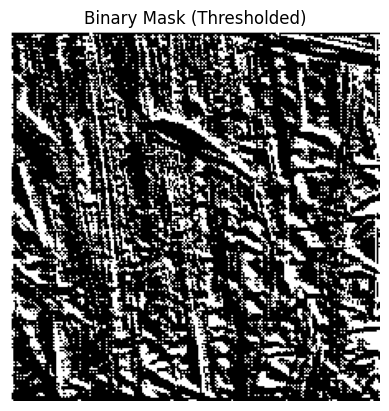


--- Evaluating on Test Data ---
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step


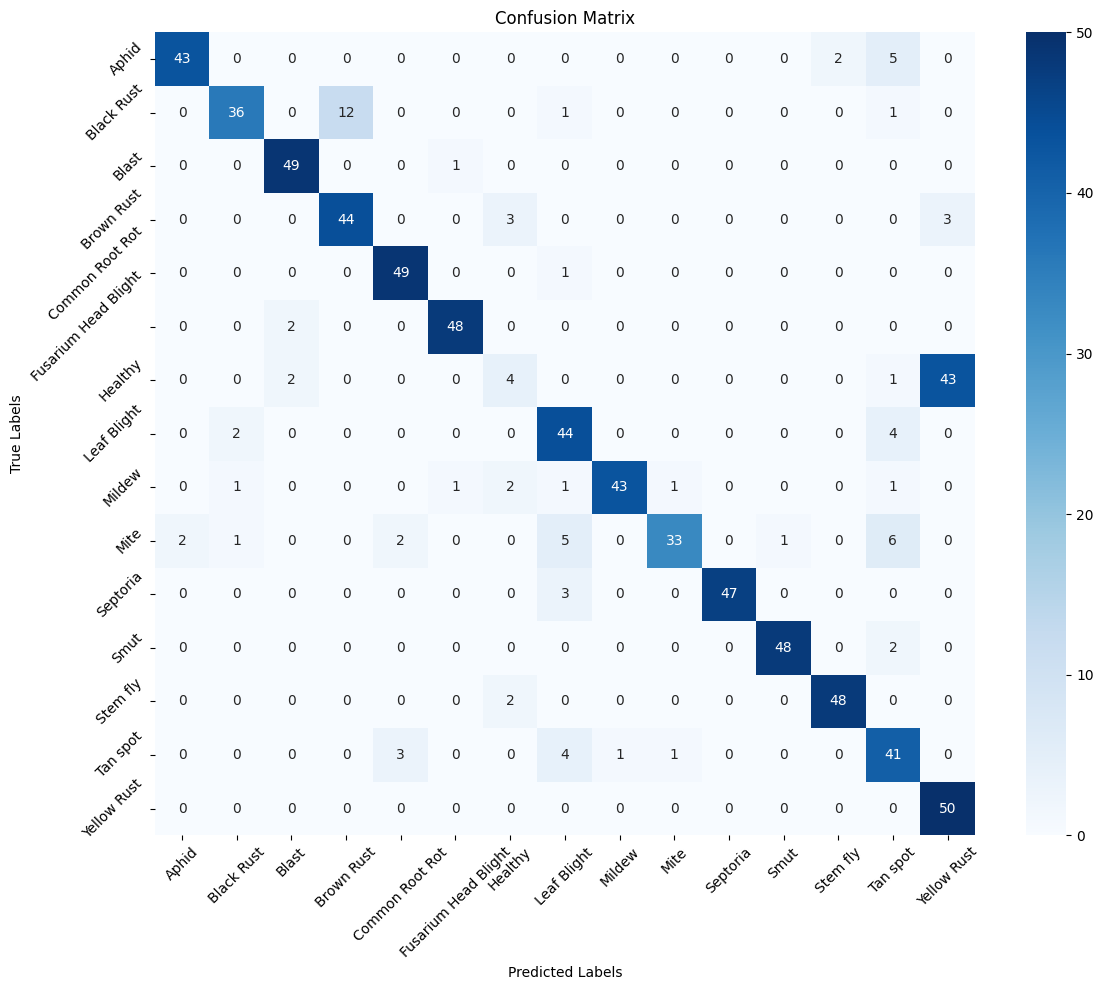

Classification Report:

                      precision    recall  f1-score   support

               Aphid       0.96      0.86      0.91        50
          Black Rust       0.90      0.72      0.80        50
               Blast       0.92      0.98      0.95        50
          Brown Rust       0.79      0.88      0.83        50
     Common Root Rot       0.91      0.98      0.94        50
Fusarium Head Blight       0.96      0.96      0.96        50
             Healthy       0.36      0.08      0.13        50
         Leaf Blight       0.75      0.88      0.81        50
              Mildew       0.98      0.86      0.91        50
                Mite       0.94      0.66      0.78        50
            Septoria       1.00      0.94      0.97        50
                Smut       0.98      0.96      0.97        50
            Stem fly       0.96      0.96      0.96        50
            Tan spot       0.67      0.82      0.74        50
         Yellow Rust       0.52      1.00    

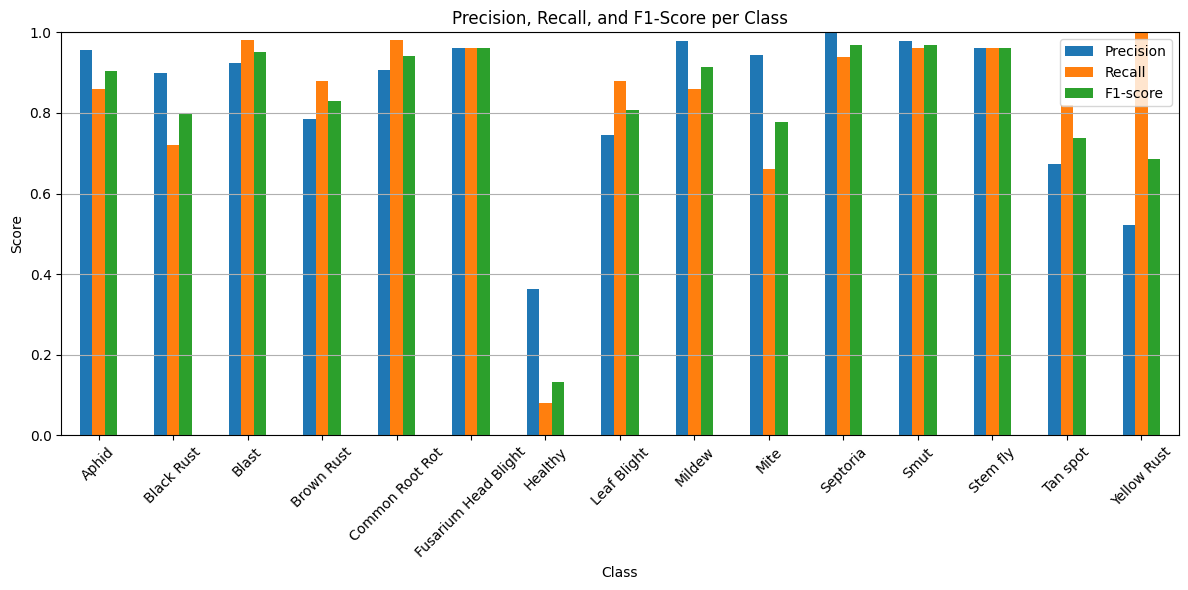

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Conv2D, Conv2DTranspose, Input, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import os
import pandas as pd

# Constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64
EPOCHS = 50

# Dataset paths
train_dir = "/kaggle/input/wheat-plant-diseases/data/train"
val_dir = "/kaggle/input/wheat-plant-diseases/data/valid"
test_dir = "/kaggle/input/wheat-plant-diseases/data/test"

# Image generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1, class_mode='categorical', shuffle=False
)

CLASS_NAMES = list(train_generator.class_indices.keys())
NUM_CLASSES = len(CLASS_NAMES)
print("Detected Classes:", CLASS_NAMES)

# Classification model (EfficientNetB0)
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
classification_model = Model(inputs=base_model.input, outputs=predictions)

classification_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

history = classification_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

classification_model.save("wheat_disease_classifier_final.keras")

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- U-Net Segmentation Model ---
def build_unet(input_shape=(224, 224, 3), num_classes=1):
    inputs = Input(input_shape)

    def conv_block(x, filters):
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        return x

    def encoder_block(x, filters):
        c = conv_block(x, filters)
        p = MaxPooling2D((2, 2))(c)
        return c, p

    def decoder_block(x, skip, filters):
        x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        x = concatenate([x, skip])
        x = conv_block(x, filters)
        return x

    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)

    bn = conv_block(p4, 1024)

    d1 = decoder_block(bn, c4, 512)
    d2 = decoder_block(d1, c3, 256)
    d3 = decoder_block(d2, c2, 128)
    d4 = decoder_block(d3, c1, 64)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(d4)

    return Model(inputs, outputs, name="U-Net")

unet_model = build_unet()
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# --- Unified Prediction Function with Mask Overlay ---
def predict_image(image_path):
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)

    # Classification Prediction
    pred = classification_model.predict(img_batch)
    class_idx = np.argmax(pred)
    confidence = pred[0][class_idx]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Class: {CLASS_NAMES[class_idx]}, Confidence: {confidence:.2f}")
    plt.show()

    if CLASS_NAMES[class_idx].lower() != "healthy":
        seg_mask = unet_model.predict(img_batch)[0]
        binary_mask = (seg_mask.squeeze() > 0.5).astype(np.uint8)

        # Convert image to uint8
        original = (img_array * 255).astype(np.uint8)
        overlay = original.copy()

        # Find contours in the binary mask
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contours, -1, (255, 0, 0), 2)  # Blue contours

        # Blend original + overlay
        blended = cv2.addWeighted(original, 0.8, overlay, 0.2, 0)

        plt.figure(figsize=(6, 6))
        plt.imshow(blended)
        plt.axis('off')
        plt.title("Segmented Diseased Area")
        plt.show()

        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')
        plt.title("Binary Mask (Thresholded)")
        plt.show()

# Example call
predict_image("/kaggle/input/wheat-plant-diseases/data/train/Black Rust/black_rust_1.png")

# --- Evaluation on Test Set ---
print("\n--- Evaluating on Test Data ---")
test_generator.reset()
preds = classification_model.predict(test_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# Metrics bar chart
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=range(NUM_CLASSES))
metrics_df = pd.DataFrame({
    'Class': CLASS_NAMES,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
})

print("\nDetailed Metrics per Class:")
print(metrics_df)

metrics_df.set_index('Class')[['Precision', 'Recall', 'F1-score']].plot(kind='bar', figsize=(12, 6), ylim=(0, 1))
plt.title("Precision, Recall, and F1-Score per Class")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Conv2D, Conv2DTranspose, Input, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import os
import pandas as pd

# Constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64
EPOCHS = 100

# Dataset paths
train_dir = "/kaggle/input/wheat-plant-diseases/data/train"
val_dir = "/kaggle/input/wheat-plant-diseases/data/valid"
test_dir = "/kaggle/input/wheat-plant-diseases/data/test"

# Image generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1, class_mode='categorical', shuffle=False
)

CLASS_NAMES = list(train_generator.class_indices.keys())
NUM_CLASSES = len(CLASS_NAMES)
print("Detected Classes:", CLASS_NAMES)

# Classification model (EfficientNetB0)
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
classification_model = Model(inputs=base_model.input, outputs=predictions)

classification_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

history = classification_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

classification_model.save("wheat_disease_classifier_final.keras")

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- U-Net Segmentation Model ---
def build_unet(input_shape=(224, 224, 3), num_classes=1):
    inputs = Input(input_shape)

    def conv_block(x, filters):
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        return x

    def encoder_block(x, filters):
        c = conv_block(x, filters)
        p = MaxPooling2D((2, 2))(c)
        return c, p

    def decoder_block(x, skip, filters):
        x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        x = concatenate([x, skip])
        x = conv_block(x, filters)
        return x

    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)

    bn = conv_block(p4, 1024)

    d1 = decoder_block(bn, c4, 512)
    d2 = decoder_block(d1, c3, 256)
    d3 = decoder_block(d2, c2, 128)
    d4 = decoder_block(d3, c1, 64)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(d4)

    return Model(inputs, outputs, name="U-Net")

unet_model = build_unet()
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# --- Unified Prediction Function with Mask Overlay ---
def predict_image(image_path):
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)

    # Classification Prediction
    pred = classification_model.predict(img_batch)
    class_idx = np.argmax(pred)
    confidence = pred[0][class_idx]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Class: {CLASS_NAMES[class_idx]}, Confidence: {confidence:.2f}")
    plt.show()

    if CLASS_NAMES[class_idx].lower() != "healthy":
        seg_mask = unet_model.predict(img_batch)[0]
        binary_mask = (seg_mask.squeeze() > 0.5).astype(np.uint8)

        # Convert image to uint8
        original = (img_array * 255).astype(np.uint8)
        overlay = original.copy()

        # Find contours in the binary mask
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contours, -1, (255, 0, 0), 2)  # Blue contours

        # Blend original + overlay
        blended = cv2.addWeighted(original, 0.8, overlay, 0.2, 0)

        plt.figure(figsize=(6, 6))
        plt.imshow(blended)
        plt.axis('off')
        plt.title("Segmented Diseased Area")
        plt.show()

        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')
        plt.title("Binary Mask (Thresholded)")
        plt.show()

# Example call
predict_image("/kaggle/input/wheat-plant-diseases/data/valid/smut_valid/smut_test_3.png")

# --- Evaluation on Test Set ---
print("\n--- Evaluating on Test Data ---")
test_generator.reset()
preds = classification_model.predict(test_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# Metrics bar chart
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=range(NUM_CLASSES))
metrics_df = pd.DataFrame({
    'Class': CLASS_NAMES,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
})

print("\nDetailed Metrics per Class:")
print(metrics_df)

metrics_df.set_index('Class')[['Precision', 'Recall', 'F1-score']].plot(kind='bar', figsize=(12, 6), ylim=(0, 1))
plt.title("Precision, Recall, and F1-Score per Class")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
